In [ ]:
# PyPSA-VGR

'''
Add a description of the prototype here.
'''

In [ ]:
# Config and imports

## Selections

START="2011-01"
END="2011-12"

## Västra götalands län
vgr_code = "14" 

## Single municipal
selected_kom_code = "1480" # Gbg

## Or all municipals
selected_kom_code = None

## Wind turbines
WIND_TURBINE = "Vestas_V25_200kW"
WIND_TURBINE = "Vestas_V47_660kW"
WIND_TURBINE = "Bonus_B1000_1000kW"
WIND_TURBINE = "Suzlon_S82_1.5_MW"
WIND_TURBINE = "Vestas_V66_1750kW"
WIND_TURBINE = "Vestas_V80_2MW_gridstreamer"
WIND_TURBINE = "Siemens_SWT_2300kW"
WIND_TURBINE = "Vestas_V90_3MW"
WIND_TURBINE_OFFSHORE = "Vestas_V90_3MW"


## Cost assumptions (get from technology-data instead)
capital_cost_per_mw_solar = 8000  # kSEK/MW
marginal_cost_per_mwh_solar = 0.125 # kSEK/MWh
capital_cost_per_mw_wind_onshore = 12500  # kSEK/MW
marginal_cost_per_mwh_wind_onshore = 0.2 # kSEK/MWh
capital_cost_per_mw_wind_offshore = 12500  # kSEK/MW TODO: put the old value back
marginal_cost_per_mwh_wind_offshore = 0.22 # kSEK/MWh TODO: put the old value back
capital_cost_per_mwh_storage = 65000  # kSEK/MWh
marginal_cost_per_mwh_storage = 0.032 # kSEK/MWh

## Basic stuff
import pypsa
import logging
import atlite
import time
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import unary_union
from shapely.geometry import Polygon
import cartopy.crs as ccrs
from datetime import datetime

logging.basicConfig(level=logging.INFO)

In [ ]:
# Create main cutout for VGR/municipality

sweden = gpd.read_file("data/geo/georef-sweden-kommun@public.geojson") #Source Lantmäteriverket, data maintained by opendatasoft.com

vgr = sweden.loc[sweden.lan_code.apply(lambda x: vgr_code in x)]

minx, miny, maxx, maxy = vgr.total_bounds

cutout = atlite.Cutout(
    path=str(f"vgr-{selected_kom_code}-{START}-{END}.nc"),
    module="era5",
    x=slice(minx, maxx),
    y=slice(miny, maxy),
    time=slice(START,END),
    dx=0.125,
    dy=0.125,
    dt="3h"
)

start_time = time.time()

cutout.prepare(features=['influx', 'temperature', 'wind'])

print("Execution time: %.4f minutes" % ((time.time() - start_time) / 60))


if selected_kom_code is None:
    selection = gpd.GeoDataFrame(geometry=[unary_union(vgr.geometry)], crs=vgr.crs)
else:
    selection = vgr.loc[vgr['kom_code'].isin(selected_kom_code)]


# EEZ (Economical zone)
shapefile_path = "data/geo/Ekonomiska_zonens_yttre_avgränsningslinjer/Ekonomiska_zonens_yttre_avgränsningslinjer_linje.shp"
eez_shape = gpd.read_file(shapefile_path).to_crs(selection.crs)
min_x, min_y, max_x, max_y = eez_shape.total_bounds
# Arbitrarily using min/max from cutout or eez to visualize it on VGR region
bounding_box = Polygon([(min_x, miny), (min_x, maxy), (maxx, maxy), (maxx, miny)])
bounds = gpd.GeoDataFrame(geometry=[bounding_box]) 
eez = gpd.overlay(eez_shape, bounds, how='intersection')

/home/viktor/miniforge3/envs/pypsa-eur/lib/python3.11/site-packages/atlite/cutout.py:190: UserWarning: Arguments module, x, y, time, dx, dy, dt are ignored, since cutout is already built.
  warn(
INFO:atlite.data:Storing temporary files in /tmp/tmpbcateqgb


Execution time: 0.0003 minutes


In [ ]:
# Exclude land use per solar/wind

import atlite
import xarray as xr
import matplotlib.pyplot as plt
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

# Source: https://www.uts.edu.au/oecm/renewable-resource-mapping
# (Classification mapping: https://collections.sentinel-hub.com/corine-land-cover/readme.html)
# With the exception of "41; Water bodies"

# Land-cover classes NOT included for solar areas:
EXCLUDED_SOLAR = [1,4,5,6,7,9,10,11,23,24,25,27,30,33,34,35,36,37,38,39,40,41,42,43,44] # 1.1.1,1.2.2,1.2.3,1.2.4,1.3.1,1.3.3,1.4.1,1.4.2,3.1.1,3.1.2,3.1.3,3.2.2,3.3.1,3.3.4,3.3.5,4.1.1,4.1.2,4.2.1,4.2.2,4.2.3,5.1.1,5.1.2,5.2.1,5.2.2,5.2.3
# Land-cover classes NOT included for wind energy areas:
EXCLUDED_WIND_NON_OCEAN = [1,2,3,4,5,6,7,9,10,11,15,16,17,23,24,25,27,30,31,33,34,35,36,37,38,39,40,41,42,43,44] # 1.1.1,1.1.2,1.2.1,1.2.2,1.2.3,1.2.4,1.3.1,1.3.3,1.4.1,1.4.2,2.2.1,2.2.2,2.2.3,3.1.1,3.1.2,3.1.3,3.2.2,3.3.1,3.3.2,3.3.4,3.3.5,4.1.1,4.1.2,4.2.1,4.2.2,4.2.3,5.1.1,5.1.2,5.2.1,5.2.2,5.2.3
INCLUDED_WIND_OCEAN = [44, 41] # 5.2.3, 5.1.2


CORINE = "data/geo/corine.tif"
solar_excluder = ExclusionContainer()
wind_onshore_excluder = ExclusionContainer()
wind_offshore_excluder = ExclusionContainer()

solar_excluder.add_raster(CORINE, codes=EXCLUDED_SOLAR)
wind_onshore_excluder.add_raster(CORINE, codes=EXCLUDED_WIND_NON_OCEAN)
wind_offshore_excluder.add_raster(CORINE, codes=INCLUDED_WIND_OCEAN, invert=True)

solar_avail = cutout.availabilitymatrix(selection, solar_excluder)
wind_onshore_avail = cutout.availabilitymatrix(selection, wind_onshore_excluder)
wind_offshore_avail = cutout.availabilitymatrix(selection, wind_offshore_excluder)

Compute availability matrix: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.56 gridcells/s]


In [ ]:
# Atlite availability results : SOLAR

solar_availability_matrix = solar_avail.stack(spatial=["y", "x"])
mean_solar_capacity_factor = cutout.pv(
    matrix=solar_availability_matrix,
    panel=atlite.solarpanels.CdTe,
    orientation="latitude_optimal",
    index=selection.index,
    per_unit =True,
)

INFO:atlite.convert:Convert and aggregate 'pv'.


In [ ]:
# Atlite availability results : WIND ONSHORE

wind_onshore_availability_matrix = wind_onshore_avail.stack(spatial=["y", "x"])
mean_wind_onshore_capacity_factor = cutout.wind(
    matrix=wind_onshore_availability_matrix,
    turbine = f"{WIND_TURBINE}",
    index=selection.index,
    per_unit =True,
)

/home/viktor/miniforge3/envs/pypsa-eur/lib/python3.11/site-packages/atlite/resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.
  warnings.warn(msg, FutureWarning)
INFO:atlite.convert:Convert and aggregate 'wind'.


In [ ]:
# Atlite availability results : WIND OFFSHORE

wind_offshore_availability_matrix = wind_offshore_avail.stack(spatial=["y", "x"])
mean_wind_offshore_capacity_factor = cutout.wind(
    matrix=wind_offshore_availability_matrix,
    turbine = f"{WIND_TURBINE_OFFSHORE}",
    index=selection.index,
    per_unit =True,
)

/home/viktor/miniforge3/envs/pypsa-eur/lib/python3.11/site-packages/atlite/resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.
  warnings.warn(msg, FutureWarning)
INFO:atlite.convert:Convert and aggregate 'wind'.


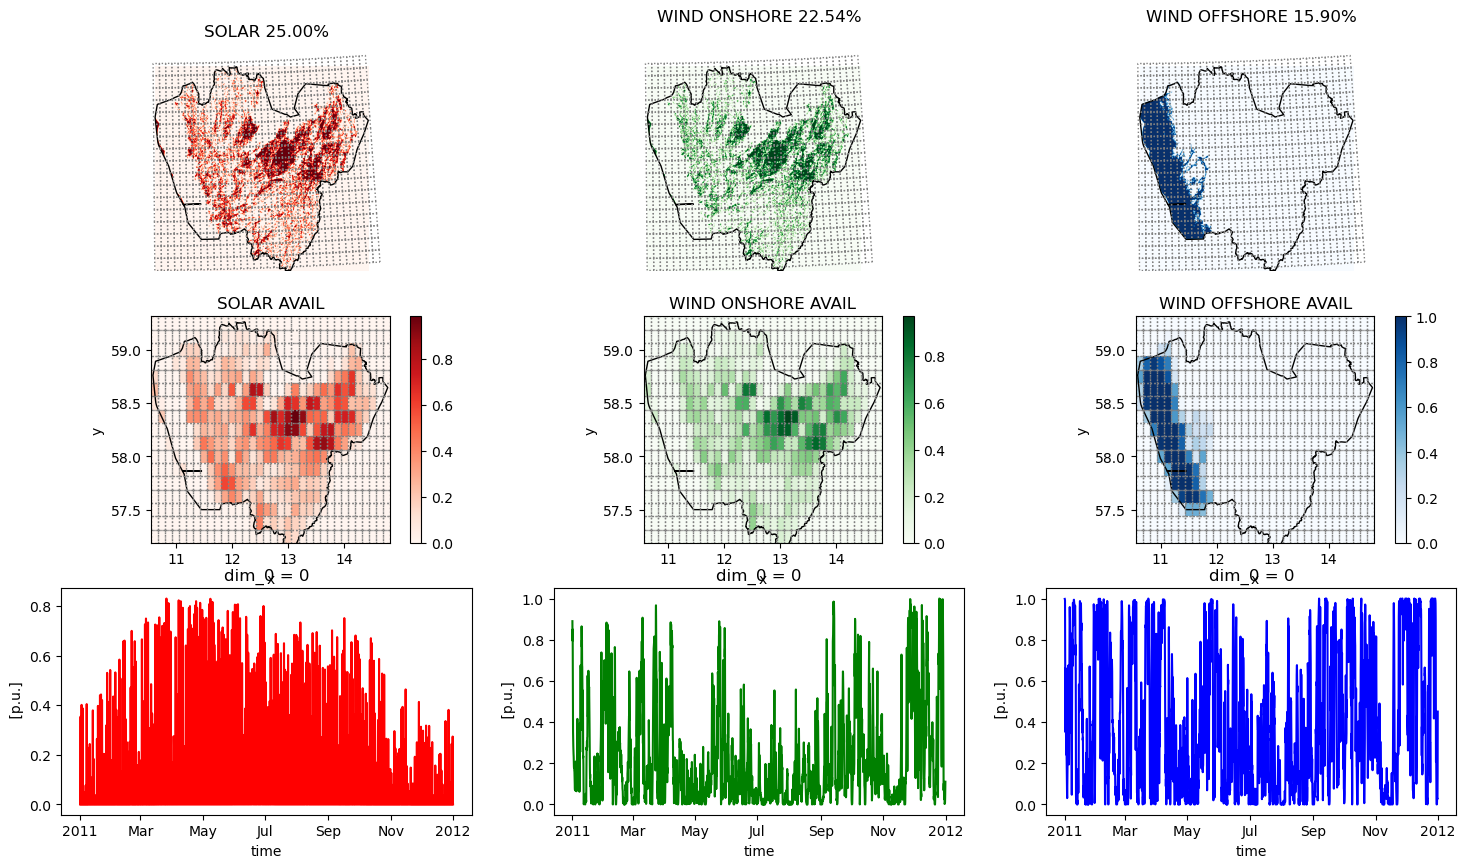

In [ ]:
# Some graphs

from matplotlib.gridspec import GridSpec

crs = selection.geometry.to_crs(solar_excluder.crs)
masked, transform = solar_excluder.compute_shape_availability(crs)
solar_eligible_share = masked.sum() * solar_excluder.res**2 / crs.geometry.item().area

crs = selection.geometry.to_crs(wind_onshore_excluder.crs)
masked, transform = wind_onshore_excluder.compute_shape_availability(crs)
wind_onshore_eligible_share = masked.sum() * wind_onshore_excluder.res**2 / crs.geometry.item().area

crs = selection.geometry.to_crs(wind_offshore_excluder.crs)
masked, transform = wind_offshore_excluder.compute_shape_availability(crs)
wind_offshore_eligible_share = masked.sum() * wind_offshore_excluder.res**2 / crs.geometry.item().area

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])

# Solar
solar_excluder.plot_shape_availability(selection, ax=ax1, show_kwargs = { "cmap": "Reds" })
cutout.grid.to_crs(solar_excluder.crs).plot(edgecolor="grey", color="None", ax=ax1, ls=":")
ax1.set_title(f"SOLAR {solar_eligible_share:.2%}")
ax1.axis("off");

# Wind (onshore)
wind_onshore_excluder.plot_shape_availability(selection, ax=ax2, show_kwargs = { "cmap": "Greens" })
cutout.grid.to_crs(wind_onshore_excluder.crs).plot(edgecolor="grey", color="None", ax=ax2, ls=":")
ax2.set_title(f"WIND ONSHORE {wind_onshore_eligible_share:.2%}")
ax2.axis("off");

# Wind (offshore)
wind_offshore_excluder.plot_shape_availability(selection, ax=ax3, show_kwargs = { "cmap": "Blues" })
cutout.grid.to_crs(wind_offshore_excluder.crs).plot(edgecolor="grey", color="None", ax=ax3, ls=":")
eez.to_crs(wind_offshore_excluder.crs).plot(color="Orange", ax=ax3)
ax3.set_title(f"WIND OFFSHORE {wind_offshore_eligible_share:.2%}")
ax3.axis("off");

# Solar avail
solar_avail.sel(dim_0=0).plot(cmap="Reds", ax=ax4)
selection.plot(ax=ax4, edgecolor="k", color="None")
cutout.grid.plot(ax=ax4, color="None", edgecolor="grey", ls=":")
ax4.set_title("SOLAR AVAIL")

# Wind (onshore) avail
wind_onshore_avail.sel(dim_0=0).plot(cmap="Greens", ax=ax5)
selection.plot(ax=ax5, edgecolor="k", color="None")
cutout.grid.plot(ax=ax5, color="None", edgecolor="grey", ls=":")
ax5.set_title("WIND ONSHORE AVAIL")

# Wind (offshore) avail
wind_offshore_avail.sel(dim_0=0).plot(cmap="Blues", ax=ax6)
selection.plot(ax=ax6, edgecolor="k", color="None")
cutout.grid.plot(ax=ax6, color="None", edgecolor="grey", ls=":")
ax6.set_title("WIND OFFSHORE AVAIL")

# Capacity factors
mean_solar_capacity_factor.plot(color="Red", ax=ax7)
mean_wind_onshore_capacity_factor.plot(color="Green", ax=ax8)
mean_wind_offshore_capacity_factor.plot(color="Blue", ax=ax9)

Max load: 110.09875315895317 MW


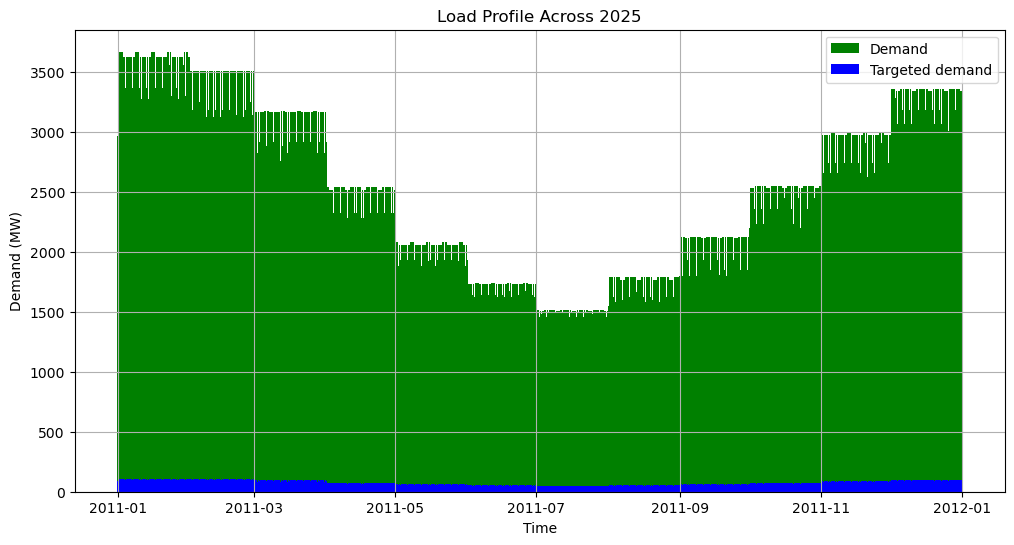

In [ ]:
# Calculate and visualize demand (source: 2025 from behovskartan.se)

import matplotlib.pyplot as plt

## Create the timeseries index
index = pd.to_datetime(cutout.coords['time'])

## Load the demand data (it comes in a format of peak demand per each hour and per month and per weekend/weekday and per h3 hexagon)
demand_data = pd.read_csv('data/demand/demand_vgr_2025.csv')
demand_year = demand_data['Year'][0]
demand_data.drop(columns=['Unnamed: 0', 'Year'], inplace=True)
demand_data['Timestamp'] = pd.to_datetime(demand_data['Timestamp'], format='%Y-%m-%d %H:%M:%S')
demand_data.set_index('Timestamp', inplace=True)

## Aggregate by summing over all the hexagons and resampling from 1h to 3h intervals
grouped_demand_data = demand_data.groupby([demand_data.index, 'Daytype']).sum()['Demand (MW)'].groupby([pd.Grouper(freq='3h', level=0), 'Daytype']).mean()

## Function that returns the appropriate demand for a given day
def select_demand(index):
    return grouped_demand_data[index.replace(year=demand_year ,day=1),'weekday' if index.weekday() < 5 else 'weekend']

## Build a load profile
target_percentage = 0.03 # This is the percentage (30%) of the demand that we want to fulfill
total_demand = [select_demand(i) for i in index]
target_load = [target_percentage*p for p in total_demand]

print("Max load: " + str(max(target_load)) + " MW")

plt.figure(figsize=(12, 6))  # Sets the figure size
plt.bar(index, total_demand, label='Demand', color='green')  # Plots the load profile against the index
plt.bar(index, target_load, label='Targeted demand', color='blue')  # Plots the load profile against the index
plt.title('Load Profile Across 2025')  # Sets the title of the graph
plt.xlabel('Time')  # Sets the label for the x-axis
plt.ylabel('Demand (MW)')  # Sets the label for the y-axis
plt.grid(True)  # Enables the grid for better readability
plt.legend()  # Adds a legend
plt.show()  # Displays the plot

/home/viktor/miniforge3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x7fc0f3020d50>,)

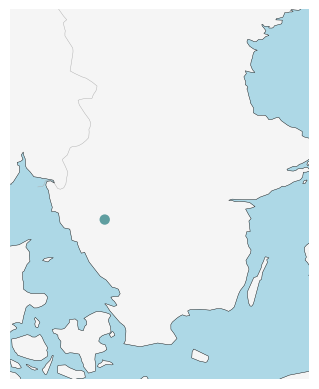

In [ ]:
# Build and visualize the network

"""
The network:

A central bus that connects a solar generator, an onshore and an offshore wind generator, a battery, and a load.

"""

## Initialize the network
network = pypsa.Network()
network.set_snapshots(index)

midx = (minx + maxx)/2
midy = (miny + maxy)/2

## Add the buses
network.add("Bus", "Main bus", x=midx, y=midy)

## Add loads
network.add("Load", "Desired load", bus="Main bus", p_set=target_load)

## Add generators
network.add("Generator", "Solar park", bus="Main bus", p_nom_extendable=True, 
            capital_cost=capital_cost_per_mw_solar, marginal_cost=marginal_cost_per_mwh_solar, 
            p_max_pu=mean_solar_capacity_factor.values.flatten())

network.add("Generator", "Wind farm onshore", bus="Main bus", p_nom_extendable=True, 
            capital_cost=capital_cost_per_mw_wind_onshore, marginal_cost=marginal_cost_per_mwh_wind_onshore, 
            p_max_pu=mean_wind_onshore_capacity_factor.values.flatten())

network.add("Generator", "Wind farm offshore", bus="Main bus", p_nom_extendable=True, 
            capital_cost=capital_cost_per_mw_wind_offshore, marginal_cost=marginal_cost_per_mwh_wind_offshore, 
            p_max_pu=mean_wind_offshore_capacity_factor.values.flatten())

## Add storage
network.add("StorageUnit", "Battery", bus="Main bus", p_nom_extendable=True, state_of_charge_initial=10,
            capital_cost=capital_cost_per_mwh_storage, marginal_cost=marginal_cost_per_mwh_storage)

network.plot(boundaries = [minx, maxx+3, miny-2.5, maxy+4], color_geomap=True, projection=ccrs.EqualEarth())



In [ ]:
# Run the optimization

## Define the objective function (minimize cost)
network.optimize()

network.model

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████| 6/6 [00:00<00:00, 170.42it/s]
INFO:linopy.io: Writing time: 0.23s
INFO:linopy.solvers:GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-40jrvagn.lp --output /tmp/linopy-solve-d_ki96m4.sol
Reading problem data from '/tmp/linopy-problem-40jrvagn.lp'...
40884 rows, 17524 columns, 77169 non-zeros
229030 lines were read
GLPK Simplex Optimizer 5.0
40884 rows, 17524 columns, 77169 non-zeros
Preprocessing...
21686 rows, 15850 columns, 56297 non-zeros
Scaling...
 A: min|aij| =  9.541e-08  max|aij| =  1.000e+00  ratio =  1.048e+07
GM: min|aij| =  1.133e-01  max|aij| =  8.826e+00  ratio =  7.790e+01
EQ: min|aij| =  1.298e-02  max|aij| =  1.000e+00  ratio =  7.706e+01
Constructing initial basis...
Size of triangular part is 21686
      0: obj =   4.247726446e+04 inf =   1.20

Linopy LP model

Variables:
----------
 * Generator-p_nom (Generator-ext)
 * StorageUnit-p_nom (StorageUnit-ext)
 * Generator-p (snapshot, Generator)
 * StorageUnit-p_dispatch (snapshot, StorageUnit)
 * StorageUnit-p_store (snapshot, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, StorageUnit)

Constraints:
------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * StorageUnit-ext-p_nom-lower (StorageUnit-ext)
 * StorageUnit-ext-p_nom-upper (StorageUnit-ext)
 * Generator-ext-p-lower (snapshot, Generator-ext)
 * Generator-ext-p-upper (snapshot, Generator-ext)
 * StorageUnit-ext-p_dispatch-lower (snapshot, StorageUnit-ext)
 * StorageUnit-ext-p_dispatch-upper (snapshot, StorageUnit-ext)
 * StorageUnit-ext-p_store-lower (snapshot, StorageUnit-ext)
 * StorageUnit-ext-p_store-upper (snapshot, StorageUnit-ext)
 * StorageUnit-ext-state_of_charge-lower (snapshot, StorageUnit-ext)
 * StorageUnit-ext-state_of_charge-upper (snapshot, StorageUni

In [ ]:
network.statistics()

,,Optimal Capacity,Installed Capacity,Capacity Factor,Dispatch,Transmission,Withdrawal,Supply,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Generator,-,2969.480,0.0,0.022603,195987.925801,0.0,0.000000,195987.925801,1.349535e+06,30908050.0,27058.513011,3.093513e+07,157.842025
Load,-,0.000,0.0,NaN,-195997.935347,0.0,195997.935347,0.000000,0.000000e+00,0.0,0.000000,-6.210261e+07,NaN
StorageUnit,-,479.459,0.0,0.117665,10.005835,0.0,82361.595067,82371.600902,0.000000e+00,31164835.0,2635.891229,3.116752e+07,378.377028
